# BPTI Spatio-temporal Decorrelation

# Identifying putative conformational substates by performing Robust Independent Component Analysis through Time-Lagged cumulant functions 

In [1]:
# invoke some initial libraries that we want as part of this setup
import matplotlib.pylab as plt
import numpy as np
import MDAnalysis as mdanal
import pyemma
import os
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt

%matplotlib inline

/Users/fxp/anaconda2/lib/python2.7/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.4, you have 2.3.2.
  .format(latest=latest, current=current), category=UserWarning)


## Select Coordinates of Interest

The function below is a generic driver for obtaining coordinates of interest. The line with Ca specifies the coordinates selected, and is based on MDAnalysis selection syntax (http://pythonhosted.org/MDAnalysis/documentation_pages/selection.html). You can use a variety of atom selections that can be returned as a numpy array.




In [2]:
def getCoordinates(pdbFileName, trjFileName):
    u = mdanal.Universe(pdbFileName, trjFileName, permissive=False);
    frames = [];
    Ca = u.select_atoms('name CA');
    for ts in u.trajectory:
        frames.append(Ca.positions.T);
    return np.array(frames);

## Loading data: BPTI ms Trajectory

This example uses the 1 millisecond trajectory of Bovine Trypsin Inhibitor (BPTI) generated by
DE Shaw Research on the Anton Supercomputer [1]. We are using only Ca-coordinates in order to manage the data size.

In [3]:
trajfile = '/Users/fxp/BPTI-Analysis/bpti_ca_1ms_dt10ns_aligned.xtc'
topfile = '/Users/fxp/BPTI-Analysis/bpti_ca.pdb'

In [4]:
feat = coor.featurizer(topfile)
feat.add_selection(feat.select_Ca());
inp = coor.source(trajfile, feat);

In [5]:
# to generate pretty plots
plt.style.use('ggplot')

We import our main library called Anharmonic conformational analysis (anca). Anca provides a number of functions that
allows one to measure anharmonicity from MD simulations. Here we demonstrate the use of anca in quantifying fourth
order statistics for a) the whole simulation and b) identifying which residues spend significant time exhibiting anharmonic fluctuations.

In [6]:
import anca

# Align Coordinates

We need to align the selected coordinates. This is to ensure that we have removed the translations and rotations and have a set of coordinates on which we can perform our analysis. anca provides support for two types of coordinate alignments: (1) The standard Kabsch alignment, and (2) an iterative alignment algorithm. You can use either function to align your trajectories.

### Note: 
We assume that you have taken care of putting protein chains or independent molecules together in the trajectories before aligning them. There are lots o pointers available, for e.g., in VMD you can use (PBCTools) [http://www.ks.uiuc.edu/Research/vmd/plugins/pbctools/]. Depending on which software you used for your simulations the procedures for putting together individual chains or molecules can be different. 

In [7]:
coords = getCoordinates(topfile, trajfile)
from anca import IterativeMeansAlign
iterAlign = IterativeMeansAlign.IterativeMeansAlign();
[itr, avgCoordsAll, eRMSDAll, newCoordsAll] = iterAlign.iterativeMeans(coords, 0.001, 12);

/Users/fxp/anaconda2/lib/python2.7/site-packages/MDAnalysis/lib/mdamath.py:151: RuntimeWarning: invalid value encountered in float_scalars
  angle = np.arccos(np.dot(a, b) / (norm(a) * norm(b)))
No handlers could be found for logger "main.IterativeMeansAlign"


In [8]:
print newCoordsAll.shape

(412497, 3, 58)


In [9]:
coordsAll = np.reshape(newCoordsAll, (len(newCoordsAll), 3*58)).T; 
avgCoordsAll = np.mean(coordsAll, 1); #print avgCoords;
tmpAll = np.reshape(np.tile(avgCoordsAll, 412497), (412497,3*58)).T; 
caDevsMDall = coordsAll - tmpAll;
print caDevsMDall.shape;

(174, 412497)


## Spatial Decorrelation of Order 2 (SD2) 

Parameters:
               
               data – a 3n x T data matrix (number 3 is due to the x,y,z coordinates for each atom). Maybe a numpy   
               array or a matrix where,
               
               n: size of the protein 
               
               T: number of snapshots of MD trajectory
               
               m – dimensionality of the subspace we are interested in; Default value is None, in which case m = n
               verbose – print information on progress. Default is true.

Returns:

               A 3n x m matrix U (NumPy matrix type), such that Y = U * data is a 2nd order spatially whitened                        
               coordinates extracted from the 3n x T data matrix. If m is omitted, U is a square 3n x 3n matrix.
               
               Ds: has eigen values sorted by increasing variance
               
               PCs: holds the index for m most significant principal components by decreasing variance S = Ds[PCs] 
    
               S – Eigen values of the ‘data’ covariance matrix
      
               B – Eigen vectors of the ‘data’ covariance matrix. The eigen vectors are orthogonal.  


In [10]:
import SD2
(Y, S, B, U) = SD2.SD2(coordsAll.T, m=174);

2nd order Spatial Decorrelation -> Looking for 174 sources
2nd order Spatial Decorrelation -> Removing the mean value
2nd order Spatial Decorrelation -> Whitening the data


In [11]:
np.savetxt('eigvectorsSD2.out',B,delimiter=',')
np.savetxt('eigenvaluesSD2.out',S,delimiter=',')

## Temporal Decorrelation of Order 2 (TD2) 

Parameters:
    
        Y -- an mxT spatially whitened matrix (m dimensionality of subspace, T snapshots). May be a numpy 
             
             array or a matrix where,
             
        m -- dimensionality of the subspace we are interested in. Defaults to None, in
                which case m=n.
        T -- number of snapshots of MD trajectory
        
        U -- whitening matrix obtained after doing the PCA analysis on m components
                of real data
        
        lag -- lag time in the form of an integer denoting the time steps
        
        verbose -- print info on progress. Default is True.
    
Returns:

      	V -- An n x m matrix V (NumPy matrix type) is a separating matrix such that V = Btd2 x U 
        (U is obtained from SD2 of data matrix and Btd2 is obtained from time-delayed covariance of matrix Y)   
      
        Z -- Z = B2td2 * Y is spatially whitened and temporally decorrelated (2nd order) source extracted from 
        the m x T spatially whitened matrix Y.        

        Dstd2: has eigen values sorted by increasing variance

        PCstd2: holds the index for m most significant principal components by decreasing variance
        R = Dstd2[PCstd2] 

        R – Eigen values of the time-delayed covariance matrix of Y
  
        Btd2 – Eigen vectors of the time-delayed covariance matrix of Y
  


In [12]:
import TD2
(Z, R, Btd2, V) = TD2.TD2(Y, m=174, U=U, lag=1000)

2nd order Temporal Decorrelation -> Looking for 174 sources
2nd order Temporal Decorrelation -> Removing the mean value
2nd order Temporal Decorrelation -> Whitening the data


In [13]:
np.savetxt('eigvectorsTD2.out',Btd2,delimiter=',')
np.savetxt('eigenvaluesTD2.out',R,delimiter=',')

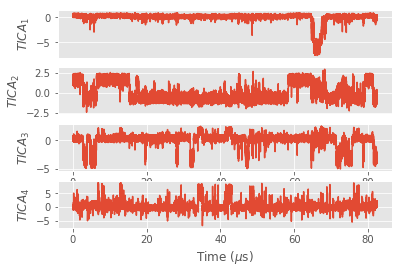

In [14]:
plt.figure();
ax1=plt.subplot(411)
x = 0.0002*np.arange(np.array(Z).shape[1])
plt.plot(x, np.array(Z)[0,:]); plt.ylabel('$TICA_1$'); plt.xticks([]); 
ax1=plt.subplot(412)
plt.plot(x, np.array(Z)[1,:]); plt.ylabel('$TICA_2$'); plt.xticks([]);  
ax1=plt.subplot(413)
plt.plot(x, np.array(Z)[2,:]); plt.ylabel('$TICA_3$'); 
ax1=plt.subplot(414)
plt.plot(x, np.array(Z)[3,:]); plt.xlabel('Time ($\mu$s)'); plt.ylabel('$TICA_4$'); 
plt.show();

## Temporal Decorrelation of Order 4 (TD4) 

Parameters:
    
        Z -- an mxT spatially uncorrelated of order 2 and temporally uncorrelated 
        of order 2 matrix (m subspaces, T samples). May be a  numpyarray or matrix where                  
                m: number of subspaces we are interested in.
                T: Number of snapshots of MD trajectory
        
        V -- separating matrix obtained after doing the PCA analysis on m components
              of real data followed temporal decorrelation of the spatially whitened 
              data
        
        lag -- lag time in the form of an integer denoting the time steps
        
        verbose -- print info on progress. Default is True.
    
Returns:
    
        W -- separating matrix    




In [15]:
import TD4
W = TD4.TD4(Z[0:10,:], m=10, V=V[0:10,:], lag=100)

4th order Temporal Decorrelation -> Estimating cumulant matrices
TD4 -> Contrast optimization by joint diagonalization
TD4 -> Sweep #  0 completed in 45 rotations
TD4 -> Sweep #  1 completed in 45 rotations
TD4 -> Sweep #  2 completed in 45 rotations
TD4 -> Sweep #  3 completed in 45 rotations
TD4 -> Sweep #  4 completed in 45 rotations
TD4 -> Sweep #  5 completed in 45 rotations
TD4 -> Sweep #  6 completed in 45 rotations
TD4 -> Sweep #  7 completed in 44 rotations
TD4 -> Sweep #  8 completed in 39 rotations
TD4 -> Sweep #  9 completed in 28 rotations
TD4 -> Sweep # 10 completed in 21 rotations
TD4 -> Sweep # 11 completed in 12 rotations
TD4 -> Sweep # 12 completed in 4 rotations
TD4 -> Sweep # 13 completed in 1 rotations
TD4 -> Sweep # 14 completed in 0 rotations
TD4 -> Total of 464 Givens rotations
TD4 -> Sorting the components
TD4 -> Fixing the signs
(10, 174)


In [16]:
ZPrj4 = W.dot(caDevsMDall)
print ZPrj4.shape

(10, 412497)


## References

1. Shaw DE, Maragakis P, Lindorff-Larsen K, Piana S, Dror RO, Eastwood MP, Bank JA, Jumper JM, Salmon JK, Shan Y,        Wriggers W: Atomic-level characterization of the structural dynamics of proteins. Science 330:341-346 (2010). doi:    10.1126/science.1187409.